# Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

2023-07-16 01:03:53.458363: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 01:03:53.586219: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Exploration

In [2]:
images_folder = '/home/images/'
listimg = os.listdir(images_folder)
EXAMPLE_IMG = plt.imread(images_folder + np.random.choice(listimg))

In [3]:
EXAMPLE_IMG.shape

(218, 178, 3)

In [4]:
# import dataset
df_attr = pd.read_csv('/home/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [5]:
try:
  df_attr.loc[listimg]
except Exception as e:
  print(e)

"['182793(1).jpg', '182809(1).jpg', '182912(1).jpg', '182943(1).jpg', '183005(1).jpg', '183018(1).jpg', '183050(1).jpg', '183111(1).jpg', '183121(1).jpg', '183145(1).jpg', '189132(1).jpg', '189297(1).jpg', '189324(1).jpg', '189512(1).jpg', '189513(1).jpg', '189581(1).jpg', '189651(1).jpg'] not in index"


Ditemukan beberapa file duplikat yang ditandai oleh (1) di akhir nama file

In [6]:
uniquelist = [img for img in listimg if not img.endswith("(1).jpg")]

In [7]:
# Filter df atribut dengan list gambar yang unik
df_unique = df_attr.loc[uniquelist]

**Lihat gambar random dari dataset**

In [ ]:
def contohgambar(imagelist):
  random_img = np.random.choice(imagelist)
  random_img_path = images_folder + random_img
  img = plt.imread(random_img_path)
  plt.imshow(img)
  print(df_unique.loc[random_img_path.split('/')[-1]][['Smiling','Male','Black_Hair']]) #some attributes

Smiling       1
Male          0
Black_Hair    1
Name: 060775.jpg, dtype: int64


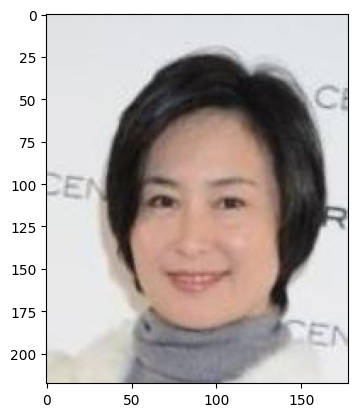

In [9]:
contohgambar(uniquelist)

**Distribusi Atribut**

Text(0, 0.5, 'Gender')

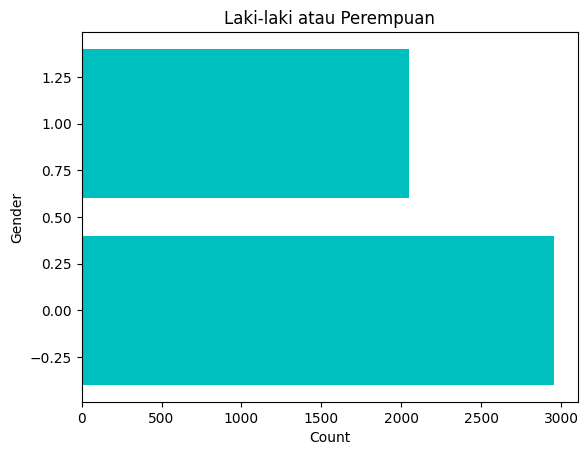

In [10]:
# # Laki-laki atau perempuan
counts = df_unique['Male'].value_counts()

# Create a bar plot
plt.barh(counts.index, counts.values, color='c')

# Set the title and axis labels
plt.title('Laki-laki atau Perempuan')
plt.xlabel('Count')
plt.ylabel('Gender')

# 2. Split Data to Train Validation, Test

In [11]:
def create_train_test(data):
    X = data.drop('Male', axis=1)
    y = data['Male']
    _, valtest, train, valtes = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    _, _, val, test = train_test_split(valtest, valtes, test_size=1/3, random_state=42, stratify=valtes)

    return train, val, test

In [12]:
train, val, test = create_train_test(df_unique)

In [13]:
def prosesdata(data):
    images = []
    for i in range(len(data)):
        img = plt.imread(images_folder + data.index[i])
        images.append(img / 255)
    y_ = tf.keras.utils.to_categorical(data)
    return np.array(images) , y_

In [14]:
trainX, trainy = prosesdata(train)
valX, valy = prosesdata(val)
testX, testy = prosesdata(test)

# 3. Build Model

In [22]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(218, 178, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

2023-07-14 03:15:10.199472: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 03:15:10.336952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14944 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


87910968/87910968 [==============================] - 6s 0us/step
number of layers: 311


In [24]:
print("number of layers:", len(inc_model.layers))


number of layers: 311


In [26]:
# Lock initial layers to do not be trained
for layer in inc_model.layers[:52]:
    layer.trainable = False
for layer in inc_model.layers[52:]:
    layer.trainable = True

#Adding custom Layers
x = inc_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model
model = Model(inputs=inc_model.input, outputs=predictions)


# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 108, 88, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [28]:
checkpointer = ModelCheckpoint(filepath='/home/model/inceptionv3noagumentation.h5',
                               verbose=1, save_best_only=True)

In [29]:
hist = model.fit(trainX, trainy
                     , validation_data = (valX, valy)
                      , epochs= 20
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20


2023-07-14 03:17:45.137650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


110/110 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8514
Epoch 1: val_loss improved from inf to 0.19144, saving model to /home/model/inceptionv3noagumentation.h5
110/110 [==============================] - 23s 140ms/step - loss: 0.3288 - accuracy: 0.8514 - val_loss: 0.1914 - val_accuracy: 0.9340
Epoch 2/20
109/110 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9765
Epoch 2: val_loss did not improve from 0.19144
110/110 [==============================] - 10s 88ms/step - loss: 0.0655 - accuracy: 0.9763 - val_loss: 0.2036 - val_accuracy: 0.9450
Epoch 3/20
109/110 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9885
Epoch 3: val_loss did not improve from 0.19144
110/110 [==============================] - 10s 89ms/step - loss: 0.0375 - accuracy: 0.9886 - val_loss: 0.2358 - val_accuracy: 0.9500
Epoch 4/20
110/110 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9934
Epoch 4: val_loss did not im

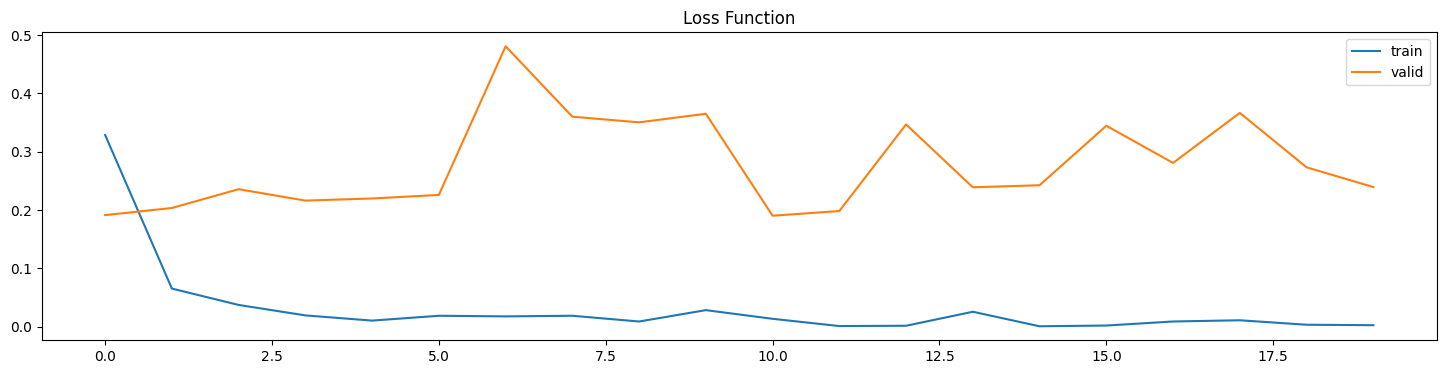

In [30]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

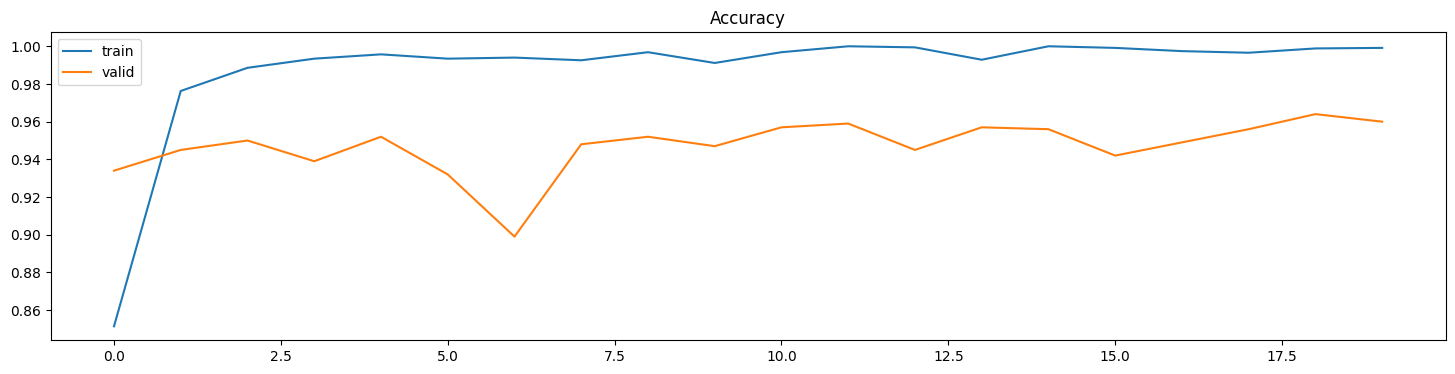

In [31]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [34]:
with open('/home/history/inceptionv3.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

# Evaluasi

In [18]:
model = tf.keras.models.load_model('/home/model/inceptionv3noagumentation.h5')

2023-07-14 06:28:58.396122: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 06:28:58.558143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14944 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [19]:
model.evaluate(testX, testy)

2023-07-14 06:29:07.581053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


16/16 [==============================] - 4s 65ms/step - loss: 0.1555 - accuracy: 0.9680


[0.15546636283397675, 0.9679999947547913]

In [20]:
pred = model.predict(testX)

16/16 [==============================] - 2s 33ms/step


In [21]:
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(testy, axis=1)

In [22]:
false_predicted = []
for i in range(len(testX)):
    if y_pred[i] != y_true[i]:
        false_predicted.append((testX[i], y_pred[i]))

In [23]:
def plot_kesalahan():
    randnum = np.random.choice(np.arange(len(false_predicted)),8, replace=False)
    fig, axes = plt.subplots(2, 4)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each image in the corresponding subplot
    for i, idx in enumerate(randnum):
        axes[i].imshow(false_predicted[idx][0], cmap='gray')
        axes[i].set_title(f'Predicted {false_predicted[idx][1]}')
        axes[i].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the figure
    plt.show()

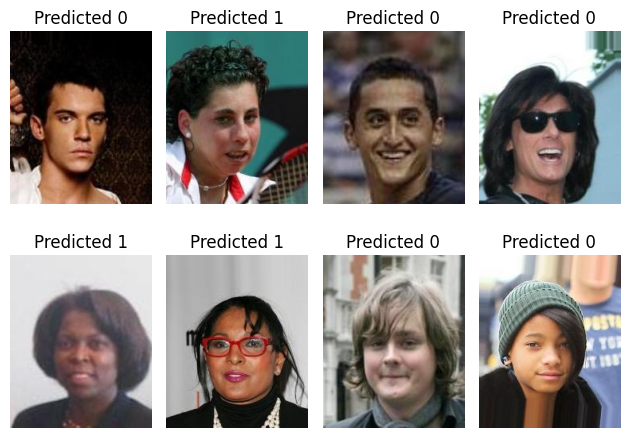

In [24]:
plot_kesalahan()

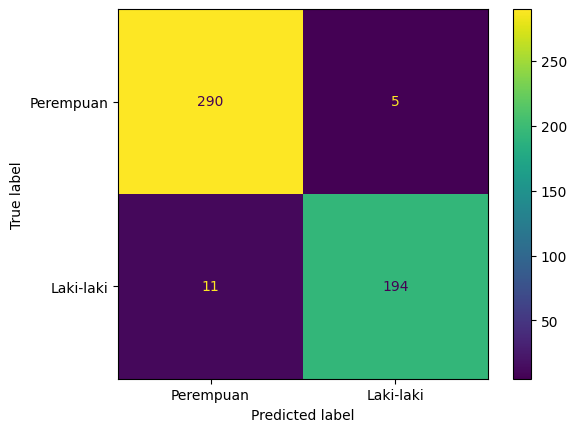

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Perempuan','Laki-laki'])
disp.plot()
plt.show()